# Machine Learning course: Project 3 - Malaria detection

## Connect to Kaggle and download Dataset

In [ ]:
# !pip install -q kaggle

# from google.colab import files
# files.upload()
# !mkdir ~/.kaggle

# !cp kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets list

In [ ]:
# !kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

In [ ]:
# !cp "/content/drive/My Drive/kaggle/cell-images-for-detecting-malaria.zip" "/content/"
# !rm -R "/content/Malaria_Detection/"
# !mkdir "/content/Malaria_Detection/"
# !mkdir "/content/Malaria_Detection/data"
# !unzip "/content/cell-images-for-detecting-malaria.zip" -d "/content/Malaria_Detection/data"

# !rm -R "/content/Malaria_Detection/data/cell_images/cell_images_padded/"
# !mkdir "/content/Malaria_Detection/data/cell_images/cell_images_padded/"
# !mkdir "/content/Malaria_Detection/data/cell_images/cell_images_padded/Parasitized"
# !mkdir "/content/Malaria_Detection/data/cell_images/cell_images_padded/Uninfected"

In [ ]:
# !rm -R "/content/Malaria_Detection/data/cell_images/cell_images/"
# !mkdir "/content/Malaria_Detection/data/cell_images/cell_images/"
# !cp -R "/content/Malaria_Detection/data/cell_images/Parasitized/" "/content/Malaria_Detection/data/cell_images/cell_images/Parasitized/" 
# !cp -R "/content/Malaria_Detection/data/cell_images/Uninfected/" "/content/Malaria_Detection/data/cell_images/cell_images/Uninfected/" 

## Load modules

In [ ]:
# Base and OS modules
import os
from glob import glob
import shutil
from collections import defaultdict
from zipfile import ZipFile
from joblib import dump, load

# Plotting and figure handling
# from matplotlib import image
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

# Data Science packages
import pandas as pd
import numpy as np
import scipy as sc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
import torch
from torch import Tensor, cuda
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision

# Debugging/Performance monitoring
import timeit
import pdb

## Define paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
paths = dict()
paths["ProjectFolder"] = "/content/" + "Malaria_Detection/"
paths["ZipFile"] = "/content/drive/My Drive/kaggle/Malaria_Detection/archive.zip" # Zip-Archiv of malaria data

# paths["ProjectFolder"] = "~/" + "Malaria_Detection/"
# paths["ZipFile"] = "~/Downloads/cell-images-for-detecting-malaria.zip" # Zip-Archiv of malaria data
paths["FeatureData"] = paths["ProjectFolder"] + "/features.csv"
paths["ImageFolder"] = paths["ProjectFolder"] + "cell_images/cell_images/"
paths["ImageFolderPadded"] = paths["ProjectFolder"] + "cell_images/cell_images_padded/"
paths["Parasitized"] = paths["ImageFolder"] + "Parasitized/"
paths["Uninfected"] = paths["ImageFolder"] + "Uninfected/"
paths["Models"] = paths["ProjectFolder"] + "models/"

## Copy data from drive to VM to increase performance

In [ ]:
os.makedirs(paths['ProjectFolder'], exist_ok=True)
os.makedirs(paths['ImageFolderPadded'], exist_ok=True)
os.makedirs(paths['Models'], exist_ok=True)

with ZipFile(paths["ZipFile"], 'r') as zip_ref:
    zip_ref.extractall(paths["ProjectFolder"] )

# Dataset
**The Dataset:** \
https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

**About the Dataset:** \
https://lhncbc.nlm.nih.gov/publication/pub9932

-- segmented and Giemsa-stained thin blood smear malaria cells of 150 falciparum infected people \
-- 50 healthy people \
-- the dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells \
-- annotated by an expert slide reader in Bangkok, Thailand \
-- a level-set based algorithm was used to detect and segment the red blood cells \

Naming Convention: PatientID+smear_type+ImageNumber \
There are CSV files availabe that map patient ID to imagine files. Not every patient has the same number of files.

# Exploratory data analysis

## Go through image folders and calculate the number of files per file extension

In [ ]:
files_dictionary = dict(defaultdict(list)) # Create dictionary to save filename + label

df = pd.DataFrame()

for image_type in range(0,2):

  if image_type == 0:
    files = glob(paths["Uninfected"] + "*", recursive=True)
    prekey = 'Uninfected'
  elif image_type == 1:
    files = glob(paths["Parasitized"] + "*", recursive=True)
    prekey = 'Infected'


  for ff, f in enumerate(files):
    
    key = "_".join((prekey, f.split(".")[-1]))
    val = "".join(f)

    if key in files_dictionary.keys():
      files_dictionary[key].append(val)
    else: 
      files_dictionary[key] = [val]

print("File types in dictionary")
print(files_dictionary.keys()) 
print("----")
print("Number of files in group")
print({key: len(val) for key, val in files_dictionary.items()})

File types in dictionary
dict_keys(['Uninfected_png', 'Uninfected_db', 'Infected_png', 'Infected_db'])
----
Number of files in group
{'Uninfected_png': 13779, 'Uninfected_db': 1, 'Infected_png': 13779, 'Infected_db': 1}


## Create Pandas dataframe with filenames and infection status

In [ ]:
df_uninfected = pd.DataFrame({"path": files_dictionary["Uninfected_png"]})
df_uninfected["Infected"] = 0
df_uninfected

df_infected = pd.DataFrame({"path": files_dictionary["Infected_png"]})
df_infected["Infected"] = 1
df_infected

df = df_uninfected.append(df_infected, ignore_index=True, verify_integrity=True)
df

,path,Infected
0,/content/Malaria_Detection/cell_images/cell_im...,0
1,/content/Malaria_Detection/cell_images/cell_im...,0
2,/content/Malaria_Detection/cell_images/cell_im...,0
3,/content/Malaria_Detection/cell_images/cell_im...,0
4,/content/Malaria_Detection/cell_images/cell_im...,0
...,...,...
27553,/content/Malaria_Detection/cell_images/cell_im...,1
27554,/content/Malaria_Detection/cell_images/cell_im...,1
27555,/content/Malaria_Detection/cell_images/cell_im...,1
27556,/content/Malaria_Detection/cell_images/cell_im...,1


All image files are of type png
.db-files are database files of the vm, which has nothing to do with the images

## Check images visually

### Uninfected cells

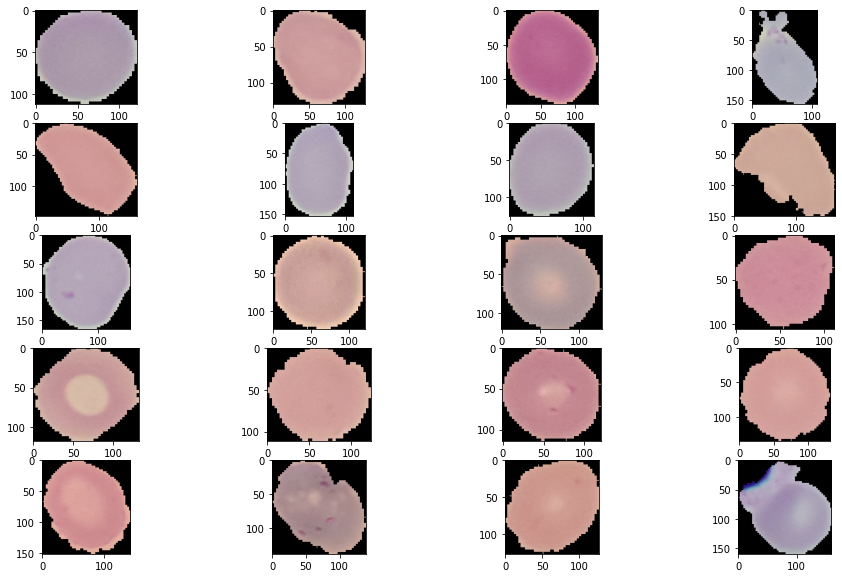

In [ ]:
f, ax = plt.subplots(5,4,figsize=(16,10))
ax = ax.flatten()

random_integer = np.random.randint(0,len(files_dictionary["Uninfected_png"]),20)
files_uninfected = files_dictionary["Uninfected_png"]

for ii,i in enumerate(random_integer):

  file_to_show = files_uninfected[ii] 
  img = Image.open("".join(file_to_show))

  ax[ii].imshow(img)

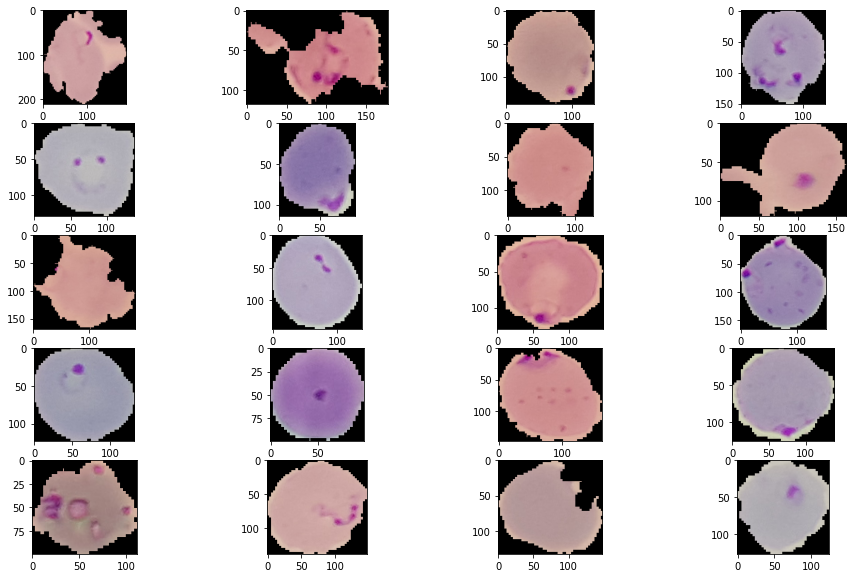

In [ ]:
f, ax = plt.subplots(5,4,figsize=(16,10))
ax = ax.flatten()

random_integer = np.random.randint(0,len(files_dictionary["Infected_png"]),20)
files_infected = files_dictionary["Infected_png"]

for ii,i in enumerate(random_integer):

  file_to_show = files_infected[ii] 
  img = Image.open("".join(file_to_show))

  ax[ii].imshow(img)

Results of visual exploration
* Infected cells show inclusion bodies and are more irregulary shaped
* Some uninfected cells show inclusion bodies as well (not shown here)
* Pixel sizes differ between pictures 

Measured to be taken: 
* Improve distingushability of inclusions by contrast tuning
* Pad and resize images to be uniformly shaped

## Unifying image sizes by padding

### Determine pixel sizes in x and y direction

In [ ]:
size_x = list() 
size_y = list() 

for ff,f in enumerate(df["path"]):

  img = Image.open(f)
  size_x.append(img.size[0])
  size_y.append(img.size[1])

df["resolution_x"] = size_x
df["resolution_y"] = size_y
N_images = df.count()

del size_x, size_y

resolution_x    46
resolution_y    40
dtype: int64
resolution_x    394
resolution_y    385
dtype: int64


,Infected,resolution_x,resolution_y
count,27558.000000,27558.000000,27558.000000
mean,0.500000,132.487154,132.983453
std,0.500009,20.015949,20.619650
min,0.000000,46.000000,40.000000
25%,0.000000,121.000000,121.000000
50%,0.500000,130.000000,130.000000
75%,1.000000,142.000000,145.000000
max,1.000000,394.000000,385.000000


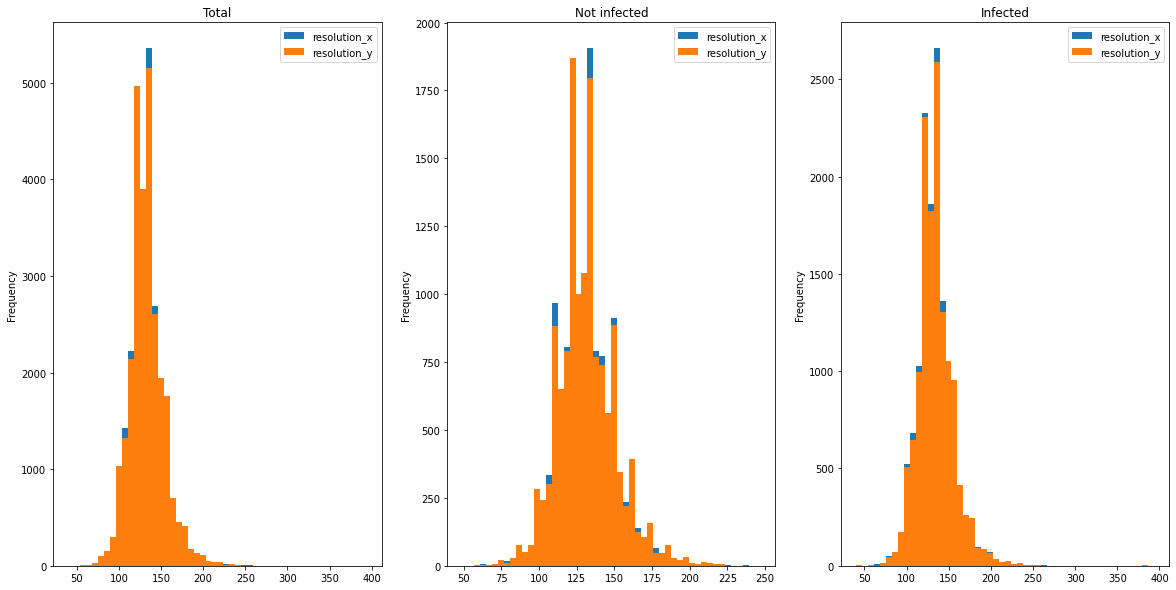

In [ ]:
print(df[["resolution_x","resolution_y"]].min())
print(df[["resolution_x","resolution_y"]].max())

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,10))

df[["resolution_x","resolution_y"]].plot.hist(bins=50, ax=ax1)
ax1.set_title("Total")
df.loc[df["Infected"] == 0][["resolution_x","resolution_y"]].plot.hist(bins=50, ax=ax2)
ax2.set_title("Not infected")
df.loc[df["Infected"] == 1][["resolution_x","resolution_y"]].plot.hist(bins=50, ax=ax3)
ax3.set_title("Infected")

df.describe()

### Pad images

Tried 400x400 px^2 as resolution as the image with the highest resolution was around 380x390 px^2, but the data size was too heavy (400 MB -> 1.6 GB) and the processing was not possible in a complete batch as the RAM was not able to hold the whole data as numpy array.

Hence, we decided to keep all pictures in the dataset, pad them to quadratic shape and resize them to 100x100 px^2. 

The corresponding total numpy array of all images in RGB takes around 3 GB of memory or in grayscale around 1 GB, which is still good to handle.

In [ ]:
max_pixel = 100

# Define background image to fill as quadaratic
ww = max_pixel
hh = max_pixel
color = (0,0,0)

filename_padded_list = list()

for ff,f in enumerate(df["path"]):

  print("Figure {}/{}".format(ff, N_images[0])) if ff % 1000 == 0 else ...
  filename = paths["ImageFolderPadded"] + f.split(sep="/")[-1]
  filename_padded_list.append(filename)

  img = Image.open(f)
  wd, ht, cc= (img.size[0], img.size[1], 3)

  max_dim = np.max([ht, wd])

  fill_img_template = np.full((max_dim,max_dim,cc), color, dtype=np.uint8)

  # compute center offset
  xx = (max_dim - wd) // 2
  yy = (max_dim - ht) // 2

  # copy img image into center of result image
  fill_img_arr = fill_img_template
  fill_img_arr[yy:yy+ht, xx:xx+wd] = img
  fill_img = Image.fromarray(fill_img_arr)

  fill_img = fill_img.resize((max_pixel,max_pixel))

  fill_img.save(filename)

df['path_padded'] = filename_padded_list

del filename_padded_list

Figure 0/27558
Figure 1000/27558
Figure 2000/27558
Figure 3000/27558
Figure 4000/27558
Figure 5000/27558
Figure 6000/27558
Figure 7000/27558
Figure 8000/27558
Figure 9000/27558
Figure 10000/27558
Figure 11000/27558
Figure 12000/27558
Figure 13000/27558
Figure 14000/27558
Figure 15000/27558
Figure 16000/27558
Figure 17000/27558
Figure 18000/27558
Figure 19000/27558
Figure 20000/27558
Figure 21000/27558
Figure 22000/27558
Figure 23000/27558
Figure 24000/27558
Figure 25000/27558
Figure 26000/27558
Figure 27000/27558


### Check padded image sizes and corresponding directory size

In [ ]:
size_x=list()
size_y=list()

for ff,f in enumerate(df["path_padded"]):

  img = Image.open(f)
  size_x.append(img.size[0])
  size_y.append(img.size[1])

df["resolution_x_padded"] = size_x
df["resolution_y_padded"] = size_y

print("All different x-y-resolutions found (for proof checking the resizing):")
print(np.unique([size_x, size_y]))

del size_x, size_y

All different x-y-resolutions found (for proof checking the resizing):
[100]


In [ ]:
!du -hs "/content/Malaria_Detection/cell_images/cell_images_padded"

286M	/content/Malaria_Detection/cell_images/cell_images_padded


Directory size: 400 MB (orignal) -> 287 MB (padded + resized)

* slight decrease due downscaling

### Contrast screening for improved differentiation of inclusions

* Here based on 5 sampled images from both groups

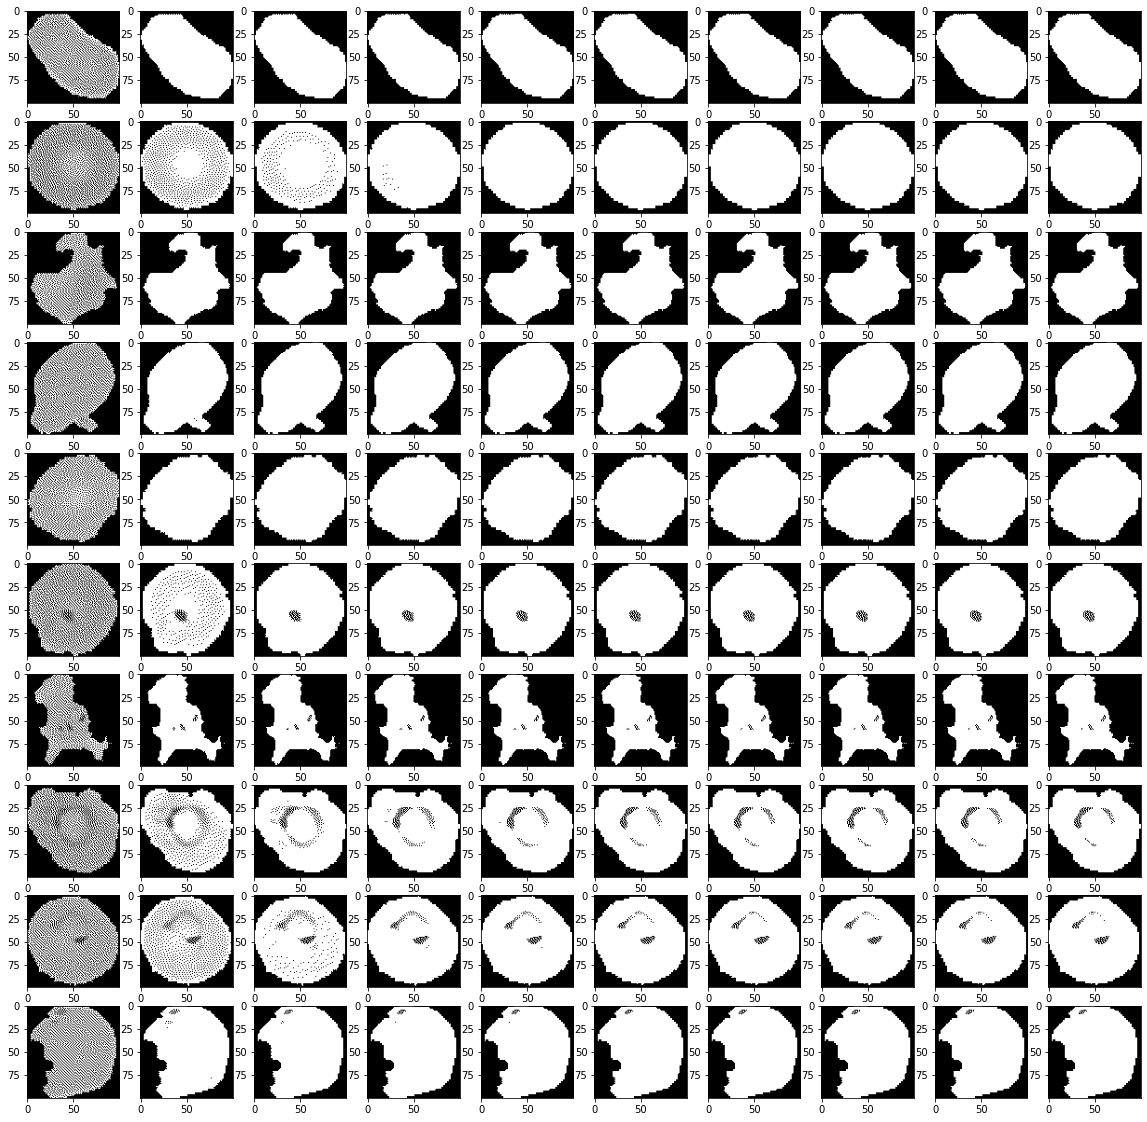

In [ ]:
fig, ax = plt.subplots(10,10,figsize=(20,20))
seed = 2020 # Seed value for reproducibility

df_sample = (
    df.loc[df["Infected"] == 0].sample(n=5, random_state=seed)
    .append(
        df.loc[df["Infected"] == 1].sample(n=5, random_state=seed)
        , ignore_index=True, verify_integrity=True)
)

for ff, f in enumerate(df_sample["path_padded"]):

  img = Image.open(f)
  contrast = ImageEnhance.Contrast(img)
  
  for cc, c in enumerate(range(1,21,2)):

    img_c = contrast.enhance(c)
    img_c = img_c.convert("1",)
    ax[ff,cc].imshow(img_c)

OptimalContrast = 11

* Contrast screening showed good results visually for a contrast value of C = 11 for bw-images, as it blurs out the color of cells and removes strange artifacts from uninfected cells. 

* For RGB images, a contrast value of 5 was sufficient to make shapes best visible. Nevertheless, applying automized methods might result in better values. 

## Transform images into numpy array

In [ ]:
for ii in range(0,2):
    if ii == 0:
      dimensions = 3
      colormode = "RGB"
      optimal_contrast = 5
      save_filename = "features_rgb.npy"

    elif ii == 1:
      dimensions = 1
      colormode = "L"
      optimal_contrast = 11
      save_filename = "features_bw.npy"


    loaded_images = list()
    fff = 0
    diff_time = 0
    tic = timeit.default_timer()

    df_template = pd.DataFrame(columns=["index", "infected", "features"])
    df_to_csv = df_template

    data = np.ndarray((df['path_padded'].count(),max_pixel,max_pixel,dimensions)).astype("float32")
    N_data = df['path_padded'].count()

    for ff,f in enumerate(df['path_padded']):

      img = Image.open(f)
      img_sw = img.convert(colormode)
      img_c = ImageEnhance.Contrast(img_sw).enhance(optimal_contrast)


      img_data = (
          np.asarray(
            img_c.getdata(),
            dtype=np.float32
          ).astype(np.float32)/255
        ).reshape((100,100,dimensions))

      data[ff, :, :, :] = img_data

      if (ff % 1000 == 0) & (ff > 1):

        toc = timeit.default_timer()
        diff_time = toc - tic
        tic = timeit.default_timer()
        print("Processed last {}/{} figures in {:.0f} s".format(ff, N_data, diff_time))


    np.save(paths['ProjectFolder'] + save_filename, data)
    df.to_csv(paths["ProjectFolder"] + "dataframe.csv", sep=",", header = True, mode = "w")

Processed last 1000/27558 figures in 9 s
Processed last 2000/27558 figures in 8 s
Processed last 3000/27558 figures in 8 s
Processed last 4000/27558 figures in 8 s
Processed last 5000/27558 figures in 8 s
Processed last 6000/27558 figures in 8 s
Processed last 7000/27558 figures in 8 s
Processed last 8000/27558 figures in 8 s
Processed last 9000/27558 figures in 8 s
Processed last 10000/27558 figures in 8 s
Processed last 11000/27558 figures in 9 s
Processed last 12000/27558 figures in 8 s
Processed last 13000/27558 figures in 8 s
Processed last 14000/27558 figures in 8 s
Processed last 15000/27558 figures in 8 s
Processed last 16000/27558 figures in 8 s
Processed last 17000/27558 figures in 8 s
Processed last 18000/27558 figures in 8 s
Processed last 19000/27558 figures in 8 s
Processed last 20000/27558 figures in 8 s
Processed last 21000/27558 figures in 8 s
Processed last 22000/27558 figures in 8 s
Processed last 23000/27558 figures in 8 s
Processed last 24000/27558 figures in 8 s
P

## Restore data

In [ ]:
# Dataframe
df = pd.read_csv(paths["ProjectFolder"] + "dataframe.csv", sep = ",")

# Numpy arrays of images
# data = np.load(paths["ProjectFolder"] + "features_bw.npy").astype('float32')
X = np.load(paths["ProjectFolder"] + "features_rgb.npy").astype('float32')

# Implementing and evaluating ML models

### Define X and y

In [ ]:
X = X.reshape(X.shape[0], -1)
y = df["Infected"].to_numpy()
 
def split_sets(X, y, RatioSample = 1, RatioTest = 0.2, RatioVal = 0.2, random_state = None):
    if RatioSample < 1:
        X, _, y, _ = train_test_split(X, y, train_size=RatioSample, stratify=y, random_state = random_state)
 
    X_train, X_test, y_train, y_test = train_test_split(
          X, y, 
          train_size=(1-RatioTest), 
          stratify=y
        )
    X_train, X_val, y_train, y_val = train_test_split(
          X_train, y_train, 
          train_size=(1-RatioVal), 
          stratify=y_train
        )
        
    return X_train, X_test, X_val, y_train, y_test, y_val

### Vanilla-Random Forest as baseline 

* We start our analysis by a Random-Forest algorithm as benchmark. Random-Forests are quite resistant against overfitting due to their bagging procedure and they do not have a lot of hyperparameters to tune. Hence, they are a good reference model.

* In the following we will use a 64% to 16% to 20% training-validation-test split, generally.

In [ ]:
tic = timeit.default_timer()

model = Pipeline(
  [('RandomForest', RandomForestClassifier()),]
)

X_train, X_test, X_val, y_train, y_test, y_val = split_sets(X, y)

model.fit(X_train, y_train)
toc = timeit.default_timer()

print("Model score: {:} %, calculated in {:.2f} s".format(model.score(X_test, y_test)*100, toc-tic))

# Save model 
dump(model, paths["Models"] + 'vanilla_RF_small.joblib') ;

Model score: 82.71044992743106 %, calculated in 145.62 s


Model score: 82.78 %

The score is a first benchmark. No hyperparameter tuning is performed here and we just test the score based on a simple train/test-split. As Random Forests are quite robust against overfitting and this is just a benchmark, we spare out the validation process.

### PCA - Scree plots und 2d-principle components plot

The image data have a high dimensionality of 100x100x3 features per image. Therefore, a dimensionality reduction might reduce the computational effort significantly. Here, we decide, after checking the scree plot, that n_components should be chosen, such that it explains 90 % of the variance. More components do not significantly contribute to the explanatory power.

Unfortunately, the PCA crashes due to heavy memory usage. Therefore, we decided to continue using grayscale images. 

In [ ]:
# Load bw-dataset
X = np.load(paths["ProjectFolder"] + "features_bw.npy").astype('float32')
df = pd.read_csv(paths["ProjectFolder"] + "dataframe.csv", sep = ",")
y = df["Infected"].to_numpy()

X = X.reshape(X.shape[0], -1)
X_train, X_test, X_val, y_train, y_test, y_val = split_sets(X, y)

In [ ]:
model = Pipeline(
  [
    ('PCA', PCA(n_components=0.90)),
  ]
)

model.fit(X_train, y_train)

# Save model 
dump(model, paths["Models"] + 'PCA.joblib') ;

PCA_transf = model.transform(X_train)

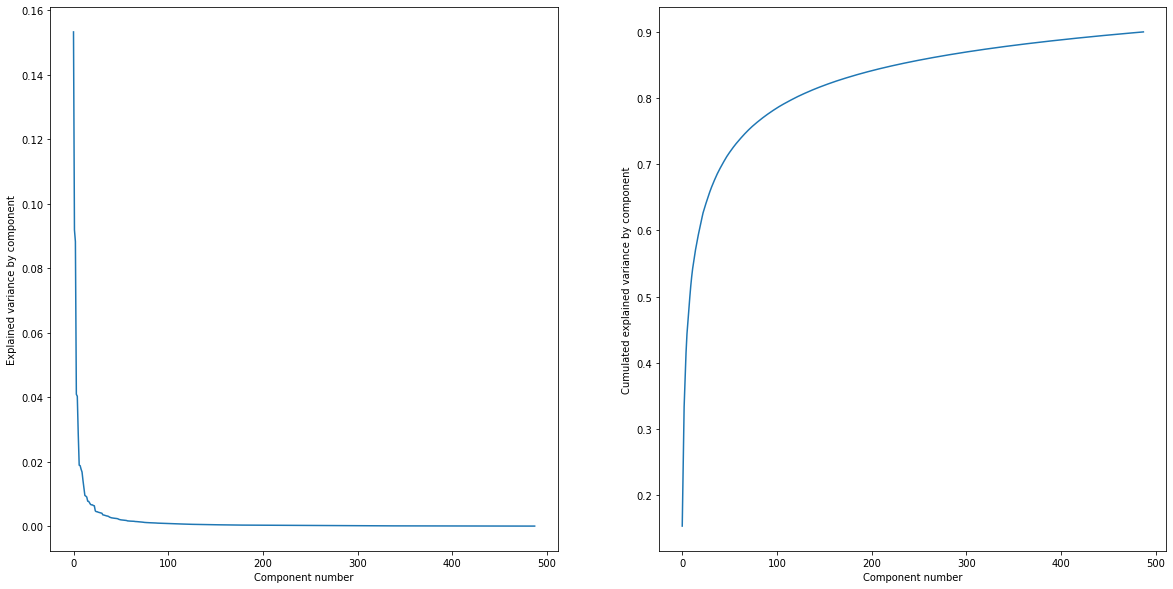

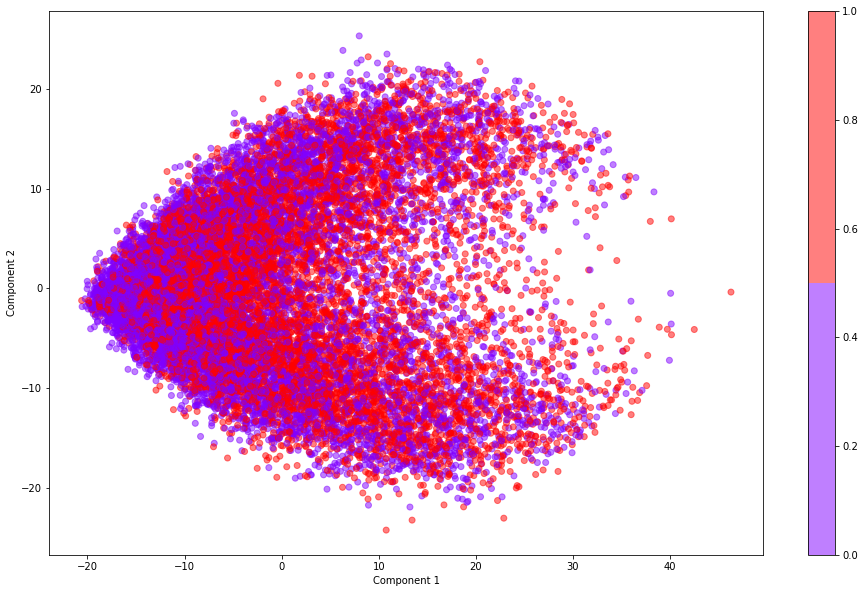

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))

# Scree plot
ax1.plot(model["PCA"].explained_variance_ratio_)
ax2.plot(model["PCA"].explained_variance_ratio_.cumsum())

ax1.set_xlabel("Component number")
ax2.set_xlabel("Component number")

ax1.set_ylabel("Explained variance by component")
ax2.set_ylabel("Cumulated explained variance by component")

# Scatter plot of two principle components 
plt.subplots(1,1,figsize=(16,10))
plt.scatter(
    PCA_transf[:,0],
    PCA_transf[:,1],
    c = y_train, 
    alpha = 0.5,
    cmap = mpl.cm.get_cmap("rainbow", 2)
)
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.colorbar();

Around 250 components seemed to be sufficient to explain around 90 % of the variance in a small dataset with around 2700 images according to the corresponding scree plots. Nevertheless, the complete data set revealed, it needs more than 500 components to represent 90 % of the variance.

### PCA + Random Forest

In [ ]:
tic = timeit.default_timer()
model = Pipeline(
  [('PCA', PCA(n_components=500)),
   ('RandomForest', RandomForestClassifier()),
  ]
)

X_train, X_test, X_val, y_train, y_test, y_val = split_sets(X, y)

model.fit(X_train, y_train)

toc = timeit.default_timer()

# Save model 
dump(model, paths["Models"] + 'PCA_RF.joblib') ;

print("Model score: {:} %, calculated in {:.2f} s".format(model.score(X_test, y_test)*100, toc-tic))

Model score: 74.12917271407838 %, calculated in 113.65 s


Model score: 73.78 %

Surprisingly, the Random Forest coupled with the PCA analyzing the grayscale images shows a worse accuracy than the Vanilla Random forest with RGB images. It is unknown yet, if the PCA reduces to many components here or if the scoring difference results from the RGB data. Anyway, we are heading towards applying a CNN, which should result in a much better score at similar computational effort (CNN performs a high performant dimensionality reduction by itself). Therefore, we do not continue to investigate this result as it might result in a dead end.


### PCA + Gradient Boosting

In [ ]:
tic = timeit.default_timer()

pipeline = Pipeline(
  [('PCA', PCA()),
   ('GB', GradientBoostingClassifier(max_depth=5)),
  ]
)

grid_spec = {
        'PCA__n_components': [300, 500, 700], 
        'GB__learning_rate': [0.5, 0.1, 0.01],
        'GB__n_estimators': [100,200,300],
    }
model = GridSearchCV(pipeline, grid_spec, cv=3, n_jobs=-1, verbose=11 )

# Overwrite gridsearchmodel in case a cross-validation might be to consuming
# model = pipeline

model.fit(X_train, y_train)

# Save model 
dump(model, paths["Models"] + 'PCA_GB.joblib') ;

toc = timeit.default_timer()

print("Model score: {:} %, calculated in {:.2f} s".format(model.score(X_test, y_test)*100, toc-tic))

Model score: 73.57 %

Surprisingly, the Gradient Booster performs not better than the random forest. Due to performance issues and a lack of accuracy, we decided not to pursue a hyperparameter optimization (see GridSearch in comment section).  


### Support vector machines

In [ ]:
X_train, X_test, X_val, y_train, y_test, y_val = split_sets(
    X, y, 
    RatioSample = 0.08, 
    RatioTest = 0.2, 
    RatioVal = 0.001, 
    random_state = None)

tic = timeit.default_timer()

pipeline = Pipeline(
    [
      ('PCA', PCA(n_components=0.9)),
      ('SVC', SVC(kernel = "rbf", C=1.3, gamma = 0.03)),
    ]
)

grid_spec = { 
'SVC__C': np.logspace(-6, 10, base=2, num=10),
'SVC__gamma': np.logspace(-5, 9, base=2, num=8)
}
model = GridSearchCV(pipeline, grid_spec, cv=5, n_jobs=-1, verbose=11 )

# model = pipeline

model.fit(X_train, y_train)

# Save model 
dump(model, paths["Models"] + 'SVC_GridCV.joblib') ;

toc = timeit.default_timer()

print("Model score: {:} %, calculated in {:.2f} s".format(model.score(X_test, y_test)*100, toc-tic))


A hyperparameter search was performed for a small part of the dataset (1600 pictures in training, 400 in test). The overall performance was quite weak in terms of computation time (several hours) and accuracy (around 60 %). Therefore, the model is withdrawn from our analysis.

Better results might be obtained for a larger dataset (probably with reduced image resolutions).

### Neural Networks

In [ ]:
# Load bw-dataset
# X = np.load(paths["ProjectFolder"] + "features_rgb.npy").astype('float32')
X = np.load(paths["ProjectFolder"] + "features_bw.npy").astype('float32')

df = pd.read_csv(paths["ProjectFolder"] + "dataframe.csv", sep = ",")
y = df["Infected"].to_numpy()

X_train, X_test, X_val, y_train, y_test, y_val = split_sets(X, y)
 
# Delete data and X to free memory
del X

In [ ]:
class trainData:
    def __init__(self, x, y):
        'Initialization'
        self.x = x
        self.y = y
 
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)
 
    def __getitem__(self, index):
        'Generates one sample of data'
        return self.x[index], self.y[index]
 
train_dataset = TensorDataset( torch.Tensor(np.transpose(X_train, (0, 3, 1, 2))), Tensor(y_train) )
test_dataset = TensorDataset( Tensor(np.transpose(X_test, (0, 3, 1, 2))), Tensor(y_test) )
val_dataset = TensorDataset( Tensor(np.transpose(X_val, (0, 3, 1, 2))), Tensor(y_val) )
 
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=1000, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=1000, shuffle=True, num_workers=2)
 
classes = ("ninf", "inf")

tensor([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1.,
        0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1.])


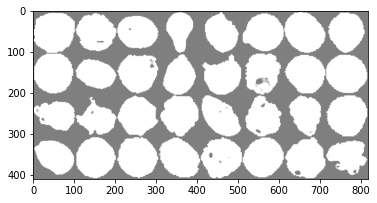

 ninf   inf   inf  ninf  ninf  ninf  ninf  ninf  ninf  ninf   inf  ninf  ninf   inf  ninf  ninf   inf   inf  ninf  ninf   inf   inf   inf  ninf  ninf  ninf  ninf  ninf   inf  ninf   inf   inf


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
 
dataiter = iter(trainloader)
images, labels = dataiter.next()
 
print(labels)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[int(labels[j])] for j in range(32)))

In [ ]:
# class Net(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(16 * 22 * 22, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 2)
 
#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 16 * 22 * 22)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
        
#         return x

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 9 * 9, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
 
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 32 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
 
 
net = Net()
 
 
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001)

--- Epoch 0 --- 
--- Epoch 1 --- 
--- Epoch 2 --- 
--- Epoch 3 --- 
--- Epoch 4 --- 
--- Epoch 5 --- 
--- Epoch 6 --- 
--- Epoch 7 --- 
--- Epoch 8 --- 
--- Epoch 9 --- 
--- Epoch 10 --- 
--- Epoch 11 --- 
--- Epoch 12 --- 
--- Epoch 13 --- 
--- Epoch 14 --- 
--- Epoch 15 --- 
--- Epoch 16 --- 
--- Epoch 17 --- 
--- Epoch 18 --- 
--- Epoch 19 --- 
Finished Training
total time elapsed:  169.86187285699998


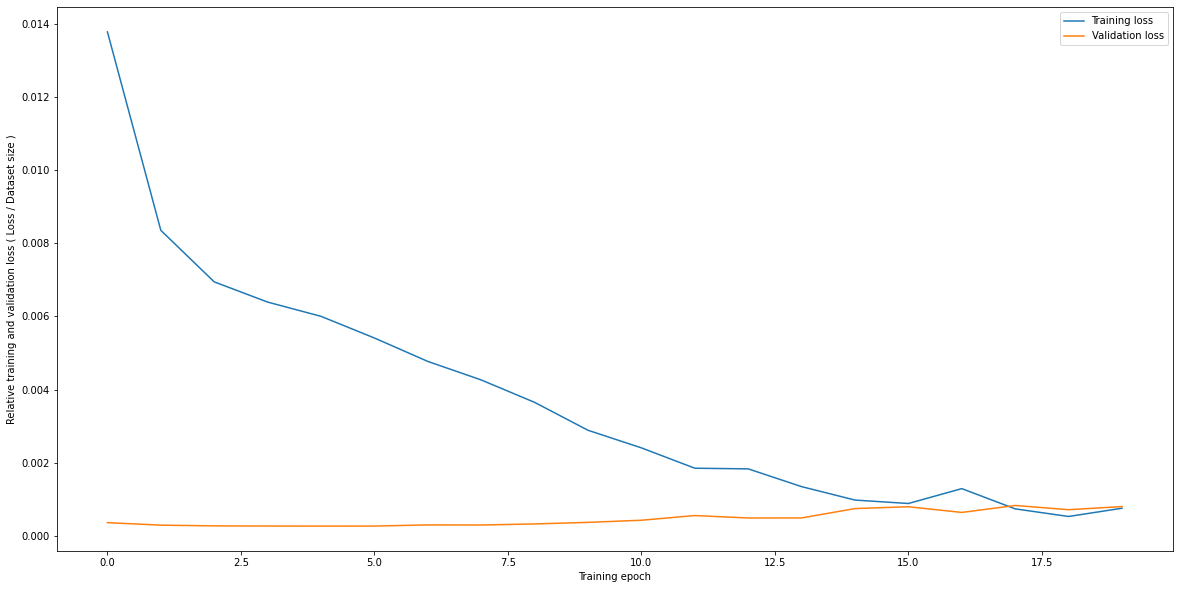

In [ ]:
N_epochs = 20
epoch_loss = np.ndarray((N_epochs))
validation_epoch_loss = np.ndarray((N_epochs))
device = torch.device('cuda:0')
net = net.to(device)
starttime = timeit.default_timer()
for ee, epoch in enumerate(range(N_epochs)): # loop over the dataset multiple times
    running_loss = 0.0
    validation_loss = 0.0

    for i, data in enumerate(trainloader, 0):
 
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
 
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels.long())
        
        loss.backward()
        optimizer.step()
 
        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999: # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            
            # running_loss = 0.0
 
    for val_data in valloader:
        val_data, val_labels = val_data[0].to(device), val_data[1].to(device)
        val_output = net(val_data)
        val_loss = criterion(val_output, val_labels.long())
        validation_loss += val_loss.item()
        
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] validation loss: %.3f' %
                  (epoch + 1, i + 1, validation_loss / 1000))
            # validation_loss = 0.0


    validation_epoch_loss[ee] = validation_loss / len(X_val)
 
    epoch_loss[ee] = running_loss / len(X_train)

    print("--- Epoch {:} --- ".format(ee))
    
# Save model 
torch.save(net.state_dict(), paths["Models"] + 'CNN_RGB_small.pt')
 
print('Finished Training')
print("total time elapsed: ", timeit.default_timer() - starttime)
 
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.plot(epoch_loss, label = "Training loss")
ax.plot(validation_epoch_loss, label = "Validation loss")
plt.xlabel("Training epoch")
plt.ylabel("Relative training and validation loss ( Loss / Dataset size )")
plt.legend();

In [ ]:
correct = 0
total = 0
# starttime = timeit.default_timer()
with torch.no_grad():
  for enum, data in enumerate(testloader):
      inputs, labels = data[0].to(device), data[1].to(device)
      outputs = net(inputs)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()          

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 90 %


# Backup results to Google Drive

In [ ]:
import shutil
shutil.make_archive(
    '/content/drive/My Drive/kaggle/Malaria_Detection/archive2',
    'zip',
    '/content/Malaria_Detection'
    )

'/content/drive/My Drive/kaggle/Malaria_Detection/archive.zip'